# Quantum Neural Networks

In the quantum computing world, it is possible to use machine learning models such as Quantum neural networks (QNN) which is a subclass of variational quantum algorithms. We have discussed the notion of feature maps that can also find applications in QNN architectures with the objective to take advantage of the quantum principles such as superposition, entanglement, and interference to increase accuracy, the speed-up in training and process the model faster. The debate between classical and quantum is still open even if some papers demonstrate theoretically an advantage of the future systems.  In Qiskit Machine Learning, there is an interface for all available neural networks. It is called NeuralNetwork and it exposes a forward and a backward pass taking the data samples and trainable weights as input. Qiskit Machine Learning provides learning algorithms such as NeuralNetworkClassifier and NeuralNetworkRegressor in order to train the neural networks. Once trained, we can use them. NeuralNetworkClassifier and NeuralNetworkRegressor take a QNN as input for classification or regression. There are multiple implementations of QNNs such as OpflowQNN which is a network based on the evaluation of quantum mechanical observables (combining parametrized quantum circuits) and the TwoLayerQNN which is a special case of the OpflowQNN taking as input a feature map and an ansatz. OpflowQNN can be used for classification wthin a NeuralNetworkClassifier. OpflowQNN is used for binary classification by assigning two classes {−1, +1} and returning a one-dimensional output [-1,+1]. The TwoLayerQNN can be a simple way to apply OpflowQNN via a feature map and an ansatz. We also add a callback function with two parameters as inputs (the current weights, the objective function value at those weights). This function is for the iterations of the optimizer. Another network is the CircuitQNN based on the samples that we get from the measure of a quantum circuit (without an observable) resulting in a probability distribution. It is used for classification (NeuralNetworkClassifier) returning d-dimensional probability vector as output where d is the number of classes. CircuitQNN can also be applied to binary classification by using parity mapping. 

In [20]:
# Loading your IBM Quantum account: https://quantum-computing.ibm.com
# It requires us to sign with an IBMQ account.
from qiskit import IBMQ
IBMQ.save_account('YOUR API', overwrite=True)
            
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

## Classification with OpflowQNN

Let’s start with a binary classification using Opflow (here we will use TwoLayerQNN) within a NeuralNetworkClassifier. 
Let’s start with a binary classification using Opflow (here we will use TwoLayerQNN) within a NeuralNetworkClassifier. In the example below, we will import a csv with the dataset we want to classify (neuron morphologies we want to classify by interneurons or principal neurons) and preprocess the data as usual: 
-	Drop row having at least 1 missing value
-	We encode the labels to be {−1, +1}
-	Divide the data, y the variable to predict (Target) and X the features
-	Splitting the data : training (X_train, y_train) and test (30%)
-	Normalize the data
-	Dimension Reduction with PCA (with two principal components)

Then we create a quantum instance and build our QNN (TwoLayerQNN), create the neural network classifier, fit the classifier to our data and give the score and prediction using our testing dataset. 
In addition we create a callback function that will be called for each iteration of the optimizer. It needs two parameters which are the current weights and the value of the objective function at those weights. 


### Preparing the data

In [60]:
# Import dataset
data = '../data/datasets/neurons_binary.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
df = neuron.head(22).copy() # Principal neurons
df = pd.concat([df, neuron.iloc[17033:17053]]) # Interneurons

# Creating an instance of Labelencoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].replace(0, -1).to_numpy() # We replace our labels by 1 and -1 and convert pandas DataFrame into numpy array

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)


### Create a QNN on Quantum

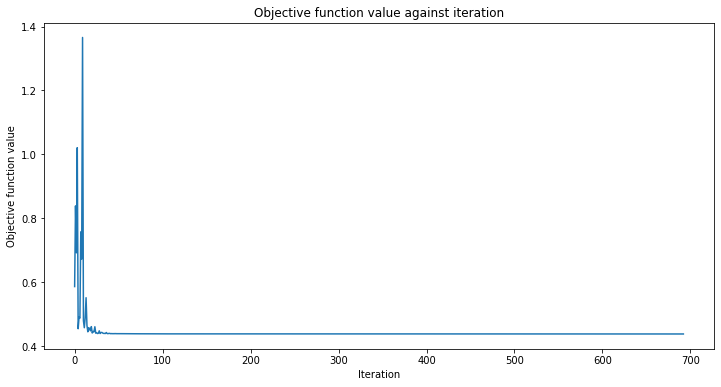

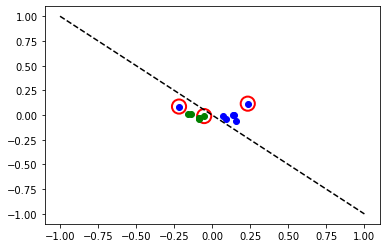

In [82]:
# Variable definition
number_inputs = 2 # Number of qubits 

# Create quantum instance
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')  
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1024)

# Build our QNN
opflow_qnn = TwoLayerQNN(number_inputs, quantum_instance=quantum_instance)

# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X_train[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Create the neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test, y_test)

# evaluate data points
y_predict = opflow_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [62]:
print(opflow_classifier.score(X_test, y_test))

0.7692307692307693


In [63]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Print predicted values and real values of the X_test dataset
print("\n")
print("Print predicted data coming from X_test as new input data")
print(y_predict)
print("\n")
print("Print real values\n")
print(y_test)
print("\n")

# Print accuracy metrics of the model
results = [metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_predict), metrics.accuracy_score(y_test, y_predict),metrics.precision_score(y_test, y_predict, average='micro'),metrics.recall_score(y_test, y_predict, average='micro'),metrics.f1_score(y_test, y_predict, average='micro')]
metrics_dataframe = pd.DataFrame(results, index=["Balanced Accuracy", "Accuracy", "Precision", "Recall", "F1 Score"], columns=['opflow_classifier'])
print('Classification Report: \n')
print(classification_report(y_test,y_predict))
        
metrics_dataframe




Print predicted data coming from X_test as new input data
[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]]


Print real values

[-1  1  1 -1  1 -1  1 -1 -1  1 -1  1  1]


Classification Report: 

              precision    recall  f1-score   support

          -1       0.71      0.83      0.77         6
           1       0.83      0.71      0.77         7

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



,opflow_classifier
Balenced Accuracy,0.773810
Accuracy,0.769231
Precision,0.769231
Recall,0.769231
F1 Score,0.769231


## Classification with a CircuitQNN

Here we will use a CircuitQNN to classify our neurons within a NeuralNetworkClassifier. 

### Preparing the data

In [23]:
# Import dataset
#data = '../data/datasets/neurons_binary.csv'
data = '../data/datasets/neurons.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
#df = neuron.head(22).copy() # Principal neurons
#df = pd.concat([df, neuron.iloc[17033:17053]]) # Interneurons

df = neuron.head(20).copy()                    # Ganglion
df = pd.concat([df, neuron.iloc[373:393]])     # Granule
df = pd.concat([df, neuron.iloc[1411:1431]])   # Medium Spiny
df = pd.concat([df, neuron.iloc[2273:2293]])   # Parachromaffin

# Creating an instance of Labelencoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].to_numpy()

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

### Create a QNN on Quantum

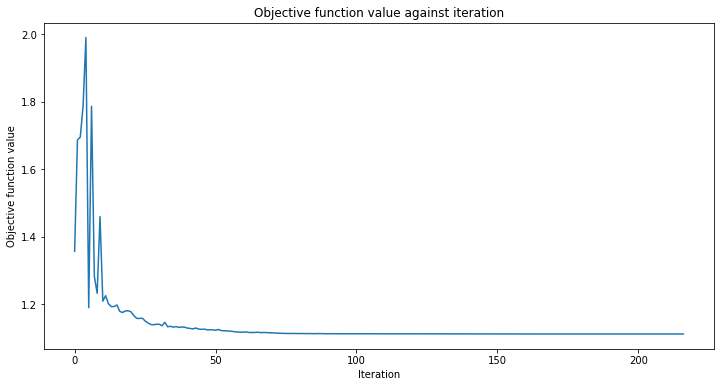

0.4166666666666667


In [24]:
# Variable definition
number_inputs = 2  # Number of qubits 
number_classes = 4 # Number of classes

# Create quantum instance
# Create quantum instance
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')   
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1024)

# construct feature map
feature_map = ZZFeatureMap(number_inputs)

# construct ansatz
ansatz = RealAmplitudes(number_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(number_inputs)
qc.append(feature_map, range(number_inputs))
qc.append(ansatz, range(number_inputs))
qc.decompose().draw()

# parity maps bitstrings to 0 or 1
#def parity(x):
#    return "{:b}".format(x).count("1") % 2

output_shape = number_classes  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
    
# Build QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
#    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Create classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X_test, y_test)

# Predict data points from X_test
y_predict = circuit_classifier.predict(X_test)
print(circuit_classifier.score(X_test, y_test))

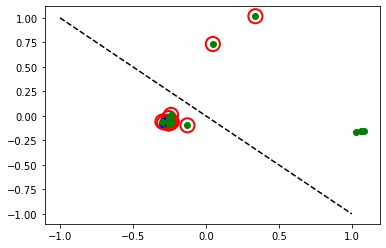

In [96]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [97]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Print predicted values and real values of the X_test dataset
print("\n")
print("Print predicted data coming from X_test as new input data")
print(y_predict)
print("\n")
print("Print real values\n")
print(y_test)
print("\n")

# Print accuracy metrics of the model
results = [metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_predict), metrics.accuracy_score(y_test, y_predict),metrics.precision_score(y_test, y_predict, average='micro'),metrics.recall_score(y_test, y_predict, average='micro'),metrics.f1_score(y_test, y_predict, average='micro')]
metrics_dataframe = pd.DataFrame(results, index=["Balanced Accuracy", "Accuracy", "Precision", "Recall", "F1 Score"], columns=['circuit_classifier'])
print('Classification Report: \n')
print(classification_report(y_test,y_predict))
        
metrics_dataframe



Print predicted data coming from X_test as new input data
[1 1 1 1 1 1 1 1 1 1 1 1 3 1 0 1 3 3 1 1 1 3 1 1]


Print real values

[1 0 1 1 0 1 0 3 0 0 2 1 3 1 3 2 3 3 2 2 0 3 0 2]


Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.32      1.00      0.48         6
           2       0.00      0.00      0.00         5
           3       1.00      0.67      0.80         6

    accuracy                           0.42        24
   macro avg       0.33      0.42      0.32        24
weighted avg       0.33      0.42      0.32        24



/Users/LRENC/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/LRENC/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/LRENC/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,circuit_classifier
Balanced Accuracy,0.416667
Accuracy,0.416667
Precision,0.416667
Recall,0.416667
F1 Score,0.416667


## Classification with Variational Quantum Classifier (VQC)

A special variant of the NeuralNetworkClassifier with a CircuitQNN is the Variational Quantum Classifier (VQC). The cross-entropy loss function is applied by default expecting labels in one-hot encoded. 

### Prepare Data

In [25]:
# Import dataset
data = '../data/datasets/neurons_binary.csv'
#data = '../data/datasets/neurons.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
df = neuron.head(22).copy() # Principal neurons
df = pd.concat([df, neuron.iloc[17033:17053]]) # Interneurons

#df = neuron.head(20).copy()                    # Ganglion
#df = pd.concat([df, neuron.iloc[373:393]])     # Granule
#df = pd.concat([df, neuron.iloc[1411:1431]])   # Medium Spiny
#df = pd.concat([df, neuron.iloc[2273:2293]])   # Parachromaffin

# Creating an instance of Labelencoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].to_numpy()

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

# One-hot encode target column
# A column will be created for each output category. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Create VQC

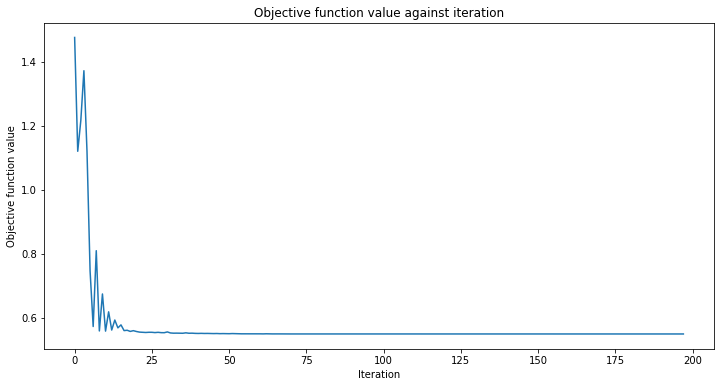

0.8461538461538461

In [27]:
# Variable definition
number_inputs = 2  # Number of quibits 
number_classes = 2 # Number of classes

# Create quantum instance
# Create quantum instance
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')   
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1024)

# Create feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(number_inputs)
ansatz = RealAmplitudes(number_inputs, reps=1)

# Create VQC
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_test, y_test)

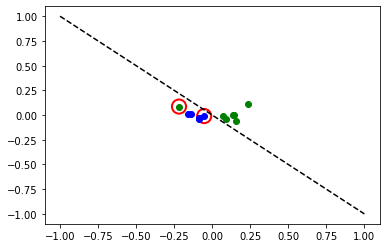

In [28]:
# evaluate data points
y_predict = vqc.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [29]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Print predicted values and real values of the X_test dataset
print("\n")
print("Print predicted data coming from X_test as new input data")
print(y_predict)
print("\n")
print("Print real values\n")
print(y_test)
print("\n")



Print predicted data coming from X_test as new input data
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


Print real values

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]




4